In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from scipy.io import loadmat
from pathlib2 import Path

In [4]:
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

In [5]:
### parameters
n_fft=4096
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-70
silence_threshold = 0.01
min_silence_for_spec=0.1
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
spectral_range = [50000, 100000]

In [6]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [7]:
MATFILE = Path('/mnt/cube/Datasets/mouse_usv/FromGregg/sample_Bl6_breathing_data.mat')

In [8]:
voc_df = loadmat(MATFILE)
voc_df = pd.DataFrame(voc_df['breathing'][0])
voc_df['length_s'] = [np.max(row.time) for idx, row in voc_df.iterrows()]
voc_df

mouse    genotype    age  \
0  [829]  [C57Bl/6J]  [P76]   
1  [832]  [C57Bl/6J]  [P76]   
2  [832]  [C57Bl/6J]  [P76]   

                                                time  \
0  [[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...   
1  [[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...   
2  [[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...   

                                            pressure  \
0  [[-0.062698364, -0.06253052, -0.062194824, -0....   
1  [[-0.016738892, -0.016723633, -0.016830444, -0...   
2  [[-0.01876831, -0.018966675, -0.019165039, -0....   

                                               audio  \
0  [[0.0017700195], [0.0007324219], [-0.002227783...   
1  [[-0.00021362305], [0.0005493164], [0.00045776...   
2  [[0.00024414062], [-0.00012207031], [6.1035156...   

                                           audioTime         fs     audioFS  \
0  [[-0.0017913372, -0.0017873376, -0.001783338, ...  [[10000]]  [[250000]]   
1  [[-0.0013908836, -0.001386884, -0.0013828843, ...  [[10000]]  [[250000]]   
2  [[-0.012664578, -0.012660579, -0.012656579, -0...  [[10000]]  [[250000]]   

     length_s  
0  204.633896  
1  104.798103  
2  141.035095

In [9]:
row = voc_df.iloc[0]

In [10]:
rate = row.audioFS[0][0]
rate

250000

In [11]:
data = row.audio.flatten()
print(len(data)/rate)
#data = data[:int(20*rate)]

204.633908


In [12]:
data = butter_bandpass_filter(data, 500, 120000, rate)

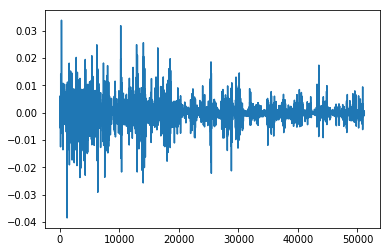

In [13]:
plt.plot(data[::1000])

In [14]:
spec = spectrogram(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
)
np.shape(spec)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


(2049, 204634)

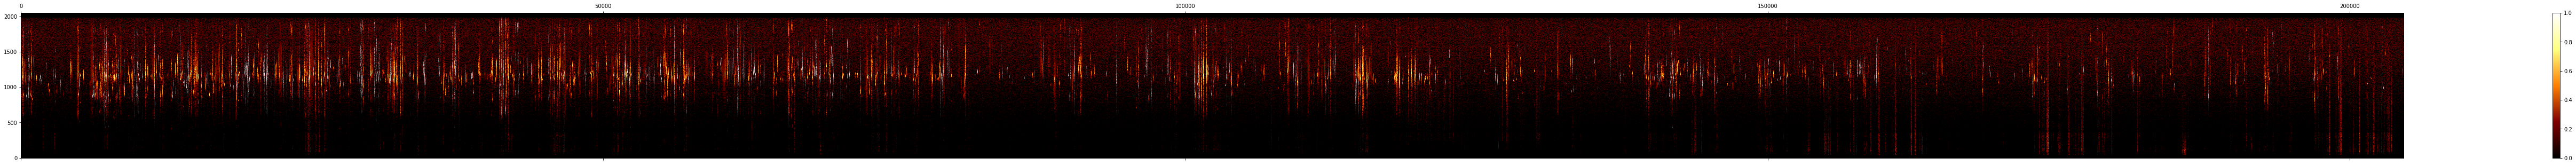

In [15]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec, fig, ax);

In [16]:
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
    silence_threshold = silence_threshold,
    verbose=True,
    spectral_range = spectral_range,
    min_syllable_length_s = min_syllable_length_s
    
)

 17%|█▋        | 1/6 [00:19<01:38, 19.60s/it]

longest silence 0.0
longest vocalization 204.634
Current min_level_db: -70


 33%|███▎      | 2/6 [00:37<01:16, 19.21s/it]

longest silence 0.0010000000000047748
longest vocalization 28.717
Current min_level_db: -65
longest silence 0.12699999999998113
longest vocalization 0.19900000000001228


In [17]:
spec = results['spec']

In [18]:
from PIL import Image

In [19]:
spec_small = np.array(Image.fromarray(spec).resize((np.shape(spec)[1], 32), Image.ANTIALIAS))

In [20]:
np.shape(spec), np.shape(spec_small)

((820, 204634), (32, 204634))

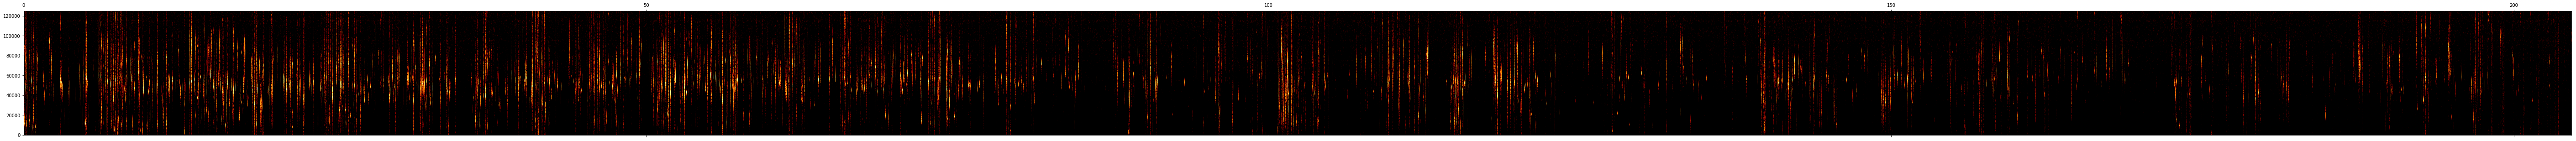

In [21]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec, fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

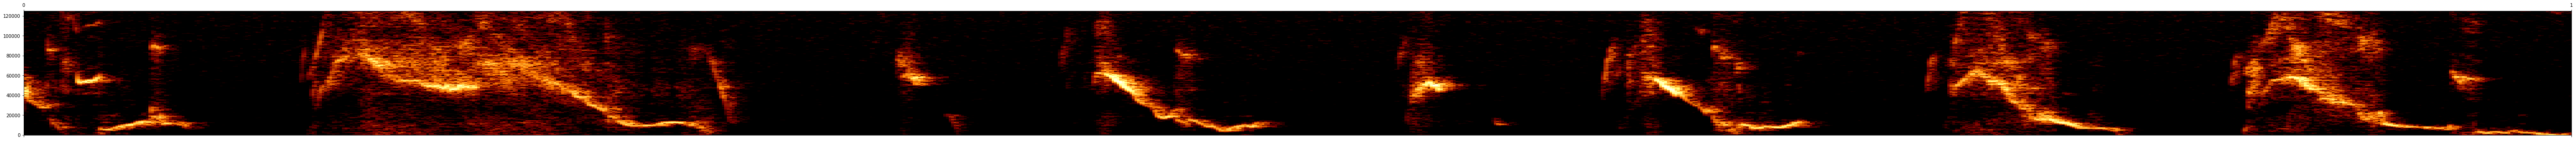

In [22]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec[:,:1000], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

### create USV segments

In [23]:
onsets, offsets = results['onsets'], results['offsets']

In [24]:
len(onsets)

1590

In [25]:
segs = [
    spec_small[:, int(onset * 1000 / hop_length_ms) : int(offset * 1000 / hop_length_ms)]
    for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets)))
]
#segs = [norm(i) for i in segs if np.prod(np.shape(i)) > 0]

Exception ignored in: <bound method tqdm.__del__ of  33%|███▎      | 2/6 [01:15<01:16, 19.21s/it]>
Traceback (most recent call last):
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


In [26]:
np.shape(segs[0]), np.shape(segs[1])

((32, 72), (32, 177))

In [27]:
len(segs)

1590

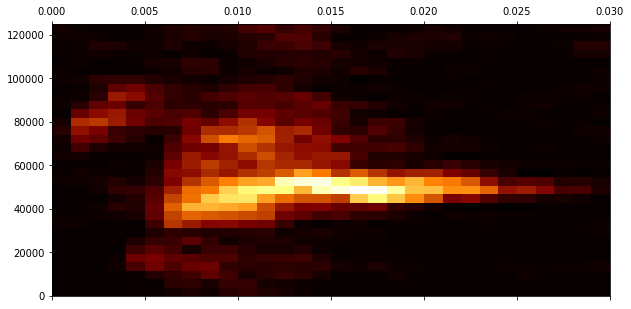

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
plot_spec(segs[4], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

### make DTW distance matrix

In [29]:
from scipy.spatial.distance import squareform

In [30]:
from avgn.metrics.dtw_mse import dtw_mse

In [31]:
dtw_mse(segs[0].T, segs[1].T)

0.0174083411693573

In [32]:
pairs = [[ai, bi]  for ai, a in enumerate(segs[:3]) for bi in np.arange(ai+1, len(segs[:3]))]
pairs

[[0, 1], [0, 2], [1, 2]]

In [33]:
pairs = [[a, segs[bi]]  for ai, a in enumerate(segs) for bi in np.arange(ai+1, len(segs))]

In [34]:
#dists = [dtw_mse(i.T, j.T) for i, j in tqdm(pairs)]

In [35]:
from joblib import Parallel, delayed

In [36]:
with Parallel(n_jobs=-1, verbose=0, prefer="threads") as parallel:
    dists = parallel(
        delayed(dtw_mse)(i.T, j.T)
        for i, j in tqdm(pairs)
    )

In [37]:
dists_square = squareform(dists)

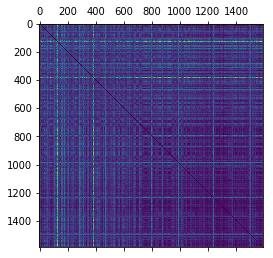

In [38]:
plt.matshow(dists_square)

### dendrogram clustering

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [40]:
linkage_matrix = linkage(dists, "single")

dn = dendrogram(
    linkage_matrix,
    p=6,
    truncate_mode="none",
    get_leaves=True,
    orientation="left",
    no_labels=True,
    link_color_func=lambda k: "k",
    show_contracted=False,
    no_plot=True
)

In [41]:
segs_sorted = [segs[i] for i in dn['leaves']]
pairs_sorted = [[a, segs_sorted[bi]] for ai, a in enumerate(segs_sorted)
                for bi in np.arange(ai + 1, len(segs_sorted))]

In [42]:
from avgn.visualization.spectrogram import draw_spec_set

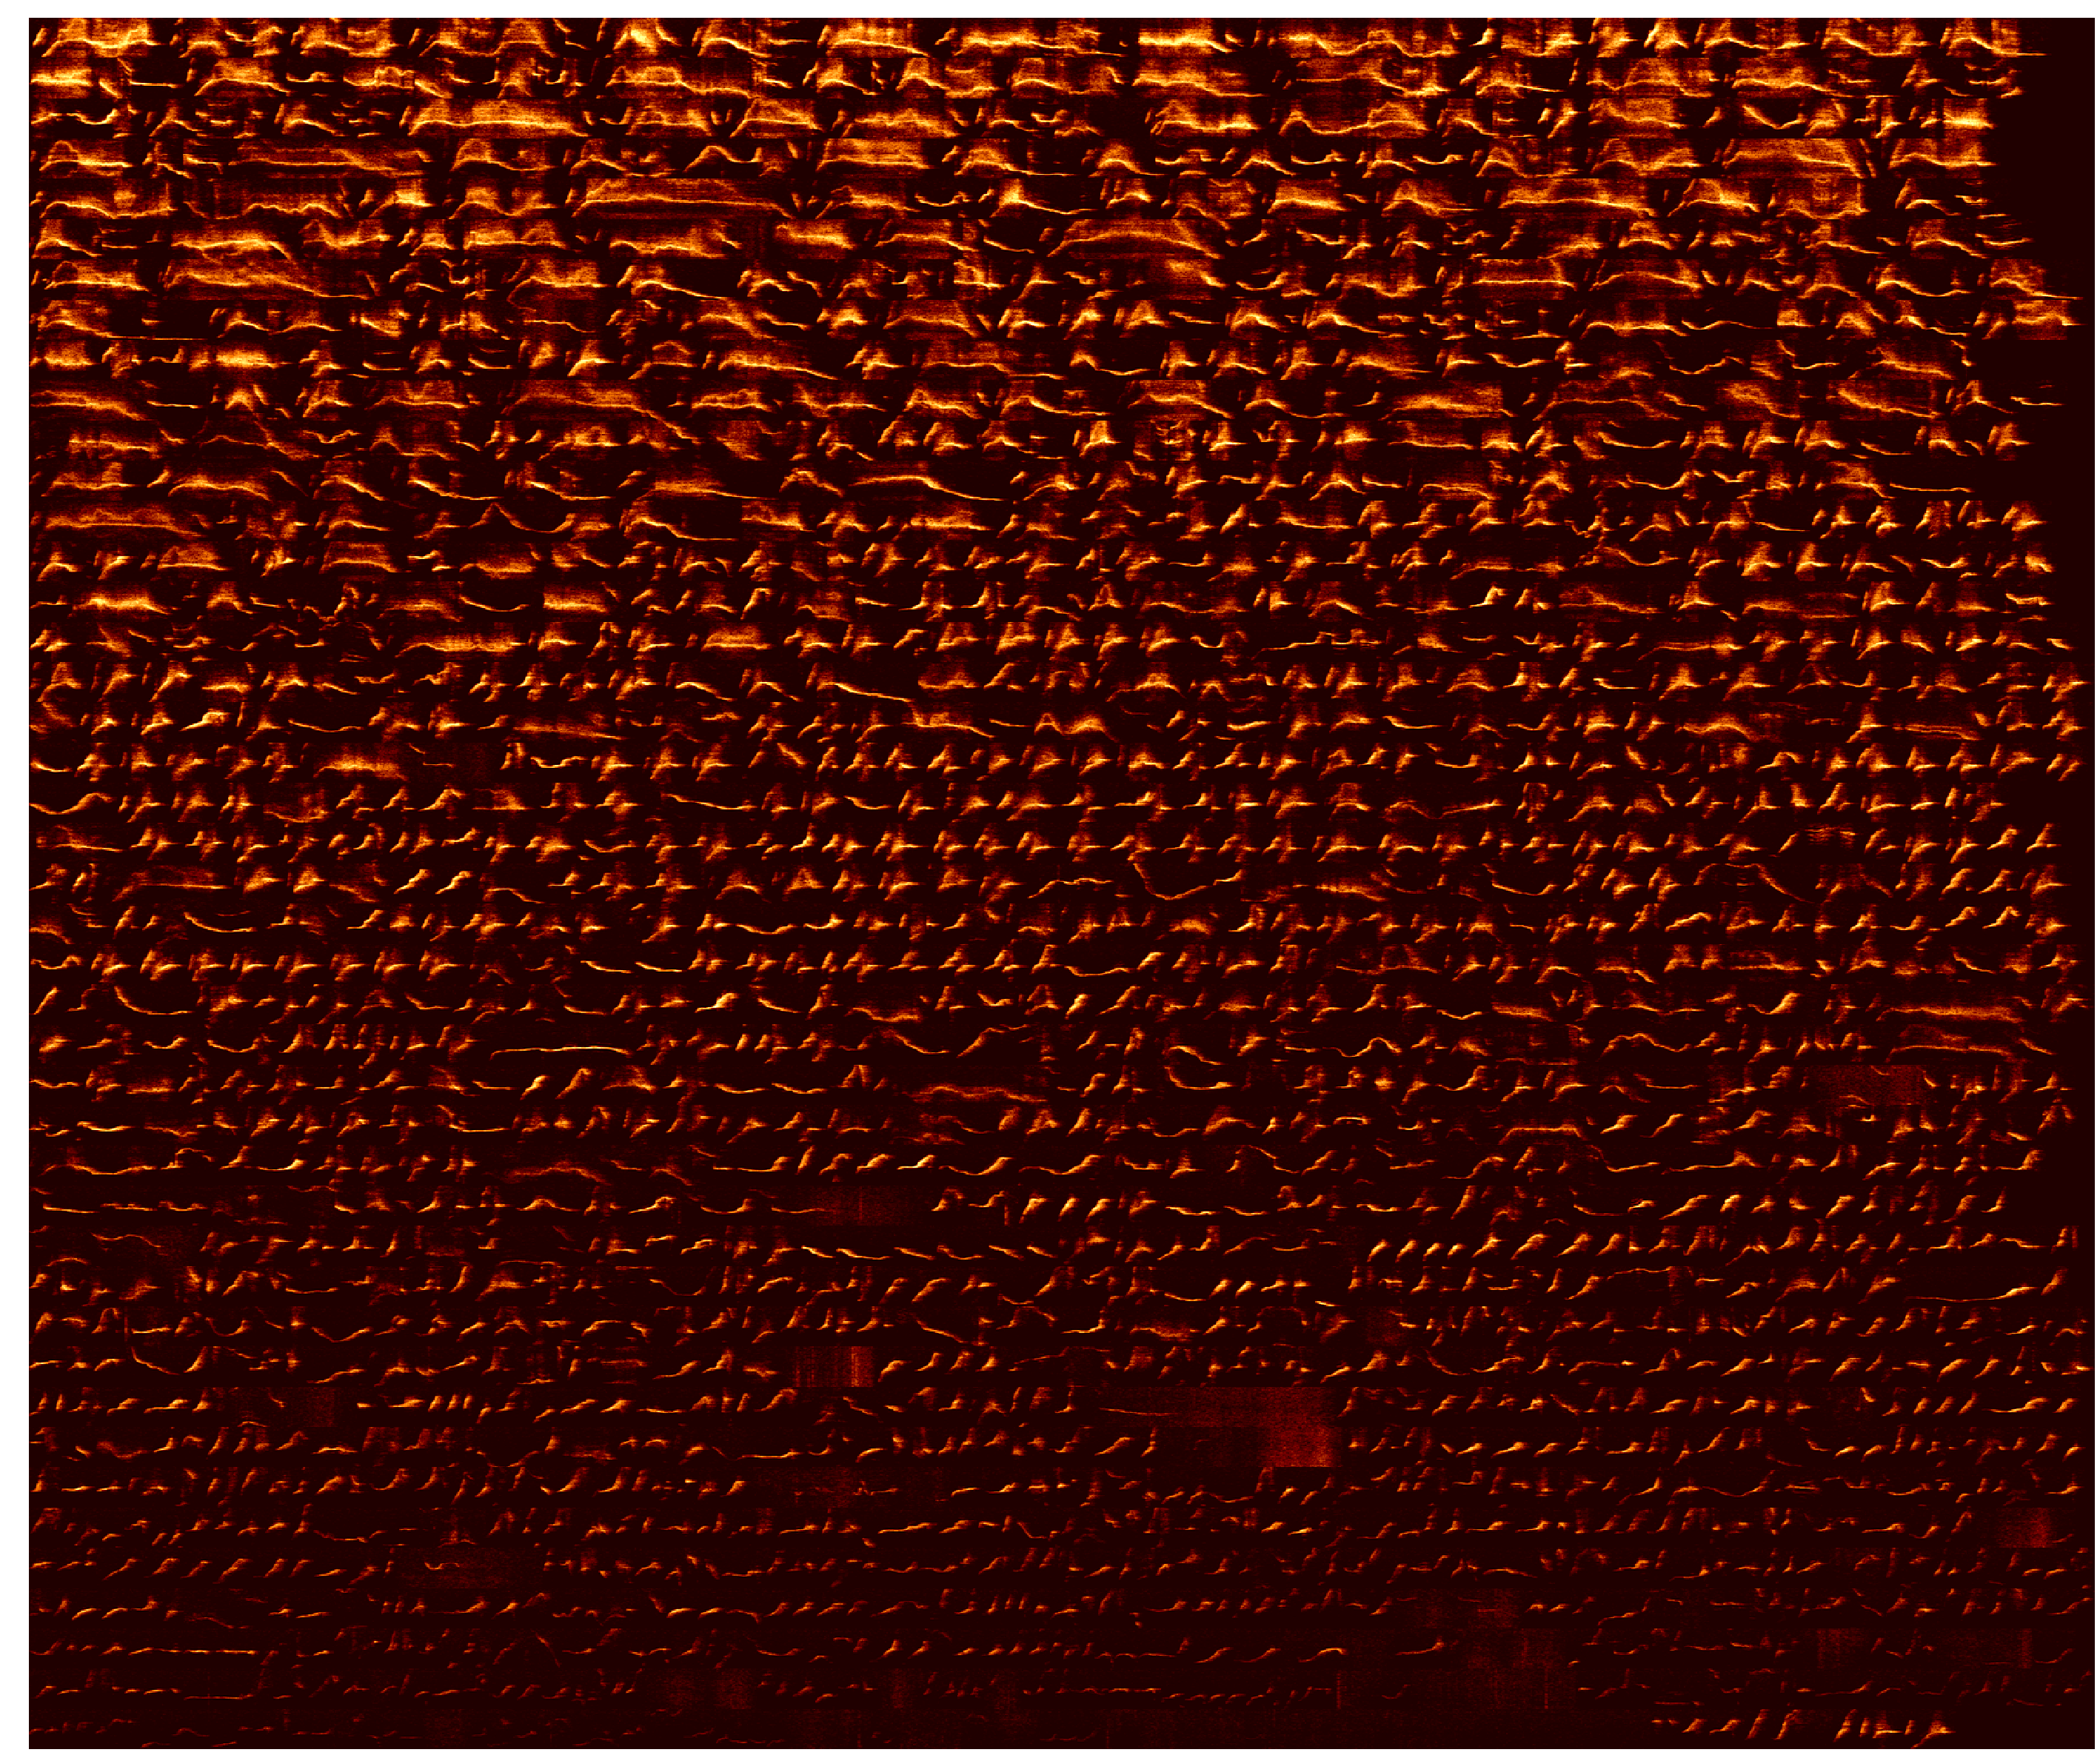

In [43]:
draw_spec_set(segs_sorted, zoom=1, maxrows=60, colsize=50)#, cmap = plt.cm.Greys)

In [44]:
dists_square_sorted = np.zeros(np.shape(dists_square))
for ii, i in enumerate(dn['leaves']):
    for ji, j in enumerate(dn['leaves']):
        dists_square_sorted[ii,ji] = dists_square[i,j]

(-0.5, 1589.5, 1589.5, -0.5)

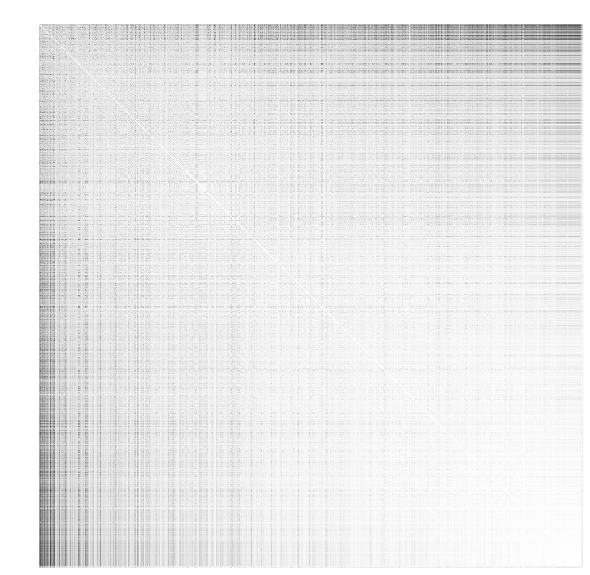

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(dists_square_sorted, cmap=plt.cm.Greys)
ax.axis('off')

### project UMAP  with a precomputed distance matrix

In [46]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [47]:
import umap

In [48]:
u = umap.UMAP(metric="precomputed")

In [49]:
z = u.fit_transform(X=dists_square)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap_learn-0.4.0rc1-py3.6.egg/umap/umap_.py:1477: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn("Using precomputed metric; transform will be unavailable for new data")


In [50]:
from avgn.visualization.projections import scatter_spec

In [51]:
np.shape(z)

(1590, 2)

In [52]:
segs_reshaped = [np.array(Image.fromarray(i).resize((32, 32), Image.ANTIALIAS)) for i in segs]

In [53]:
np.shape(segs_reshaped)

(1590, 32, 32)

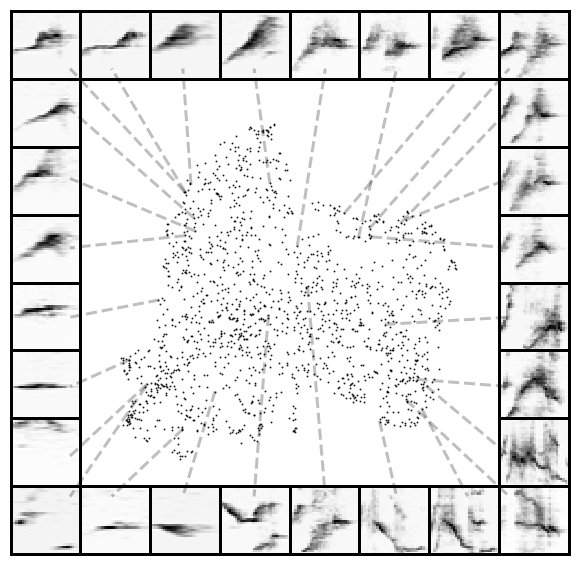

In [54]:
scatter_spec(
    z,
    segs_reshaped,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        #'labels': subset_df.labels.values,
        'alpha':.75,
        's': 1,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
#save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feats', dpi=300, save_jpg=True)

### Project umap using DTW as distance

In [76]:
from avgn.metrics.dtw_mse import build_dtw_mse

In [97]:
segs_t = np.array([i.T for i in segs])

In [98]:
np.shape(segs_t[0]), np.shape(segs_t[1])

((72, 32), (177, 32))

199


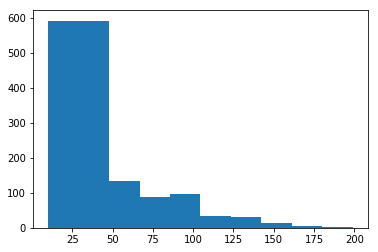

In [133]:
plt.hist([np.shape(i)[0] for i in segs_t]);
print(np.max([np.shape(i)[0] for i in segs_t]))

In [134]:
np.shape(segs_t[0])

(72, 32)

In [135]:
def pad(array, shape):
    result = np.zeros(shape)
    result[:np.shape(array)[0], :np.shape(array)[1]] = array
    return result

In [136]:
np.shape(pad(segs_t[0], (200,32)))

(200, 32)

In [140]:
segs_t_pad = np.array([pad(i, (200,32)) for i in segs_t])

In [141]:
dtw_metric = build_dtw_mse(segs_t_pad[0].shape)

In [145]:
len(segs_t_pad)

1590

In [146]:
segs_t_pad_short = segs_t_pad[:10]

In [152]:
z_umap = umap.UMAP(metric=dtw_metric).fit_transform(segs_t_pad.reshape(len(segs_t_pad), -1))

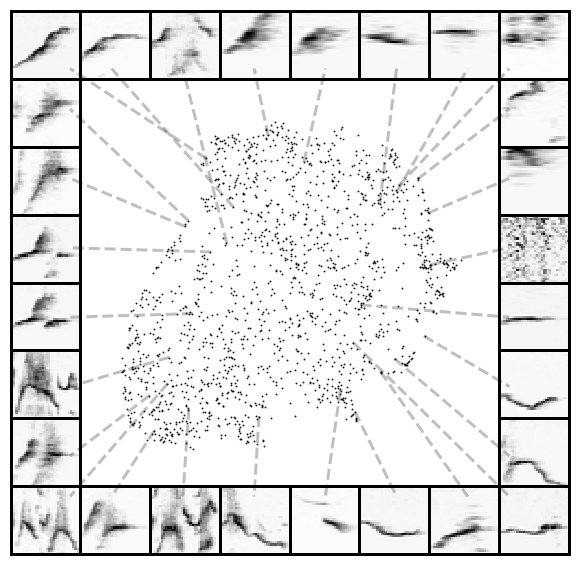

In [153]:
scatter_spec(
    z_umap,
    segs_reshaped,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        #'labels': subset_df.labels.values,
        'alpha':.75,
        's': 1,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
#save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feats', dpi=300, save_jpg=True)